# Artificial Neural Networks and Deep Learning



---



## Homework 2: Minimal Working Example

## ⚙️ Import Libraries

In [1]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2

import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ConvNeXtBase

seed = 42
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 1


## ⏳ Load the Data

In [2]:
file_path = "/kaggle/input/mars-data/mars_for_students.npz"

data = np.load(file_path)

training_set = data["training_set"]
images = training_set[:, 0]
labels = training_set[:, 1]

print(f"Training X shape: {images.shape}")
print(f"Training y shape: {labels.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)


### Some exploration (ignore)

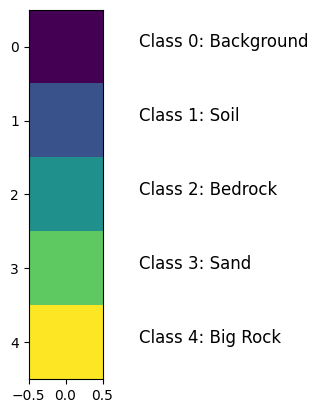

In [3]:
# Labels dictionary
labels_map = {
    0: 'Background',
    1: 'Soil',
    2: 'Bedrock',
    3: 'Sand',
    4: 'Big Rock'
}

plt.imshow([[i] for i in range(5)])
for i in range(5):
    plt.text(1, i, f'Class {i}: {labels_map[i]}', fontsize=12)

plt.show()

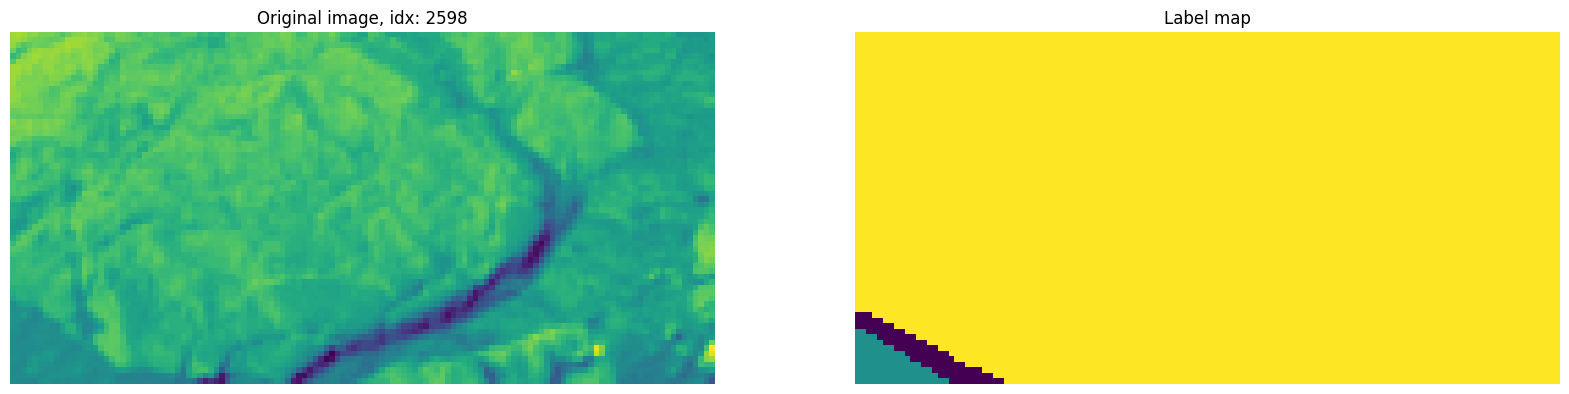

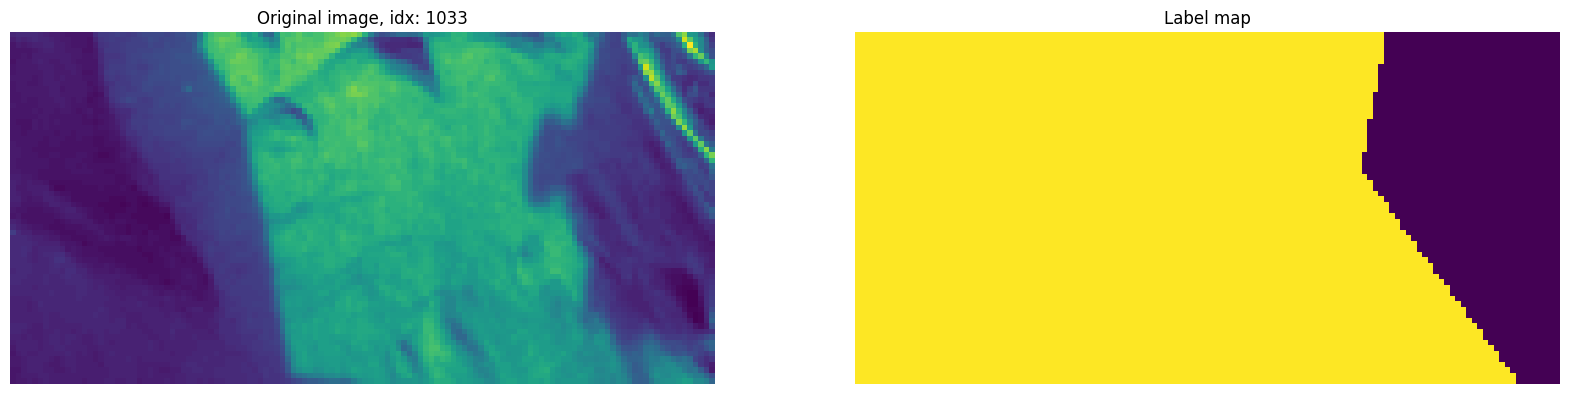

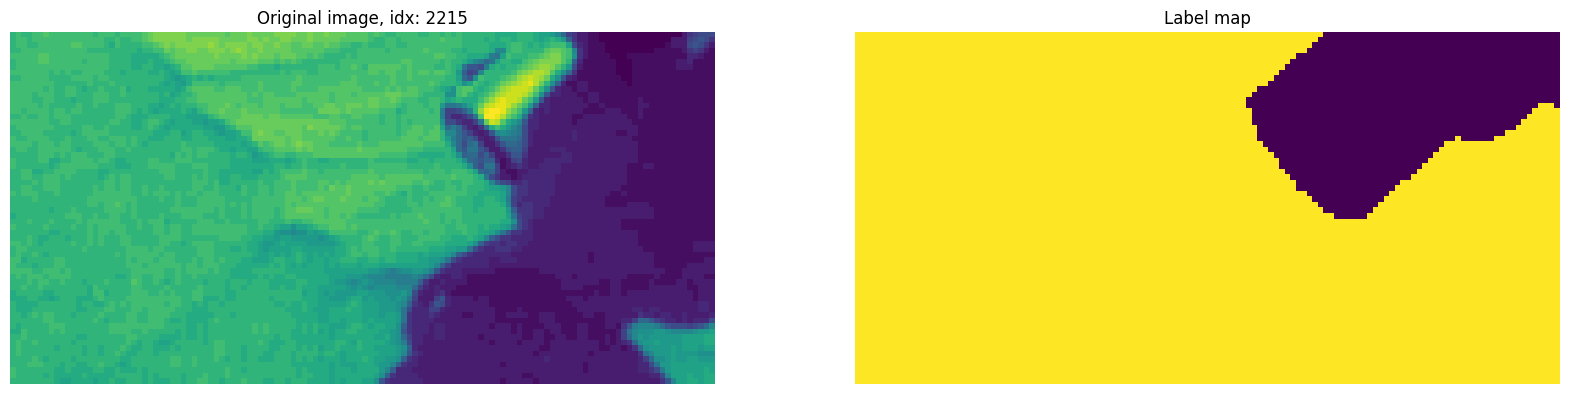

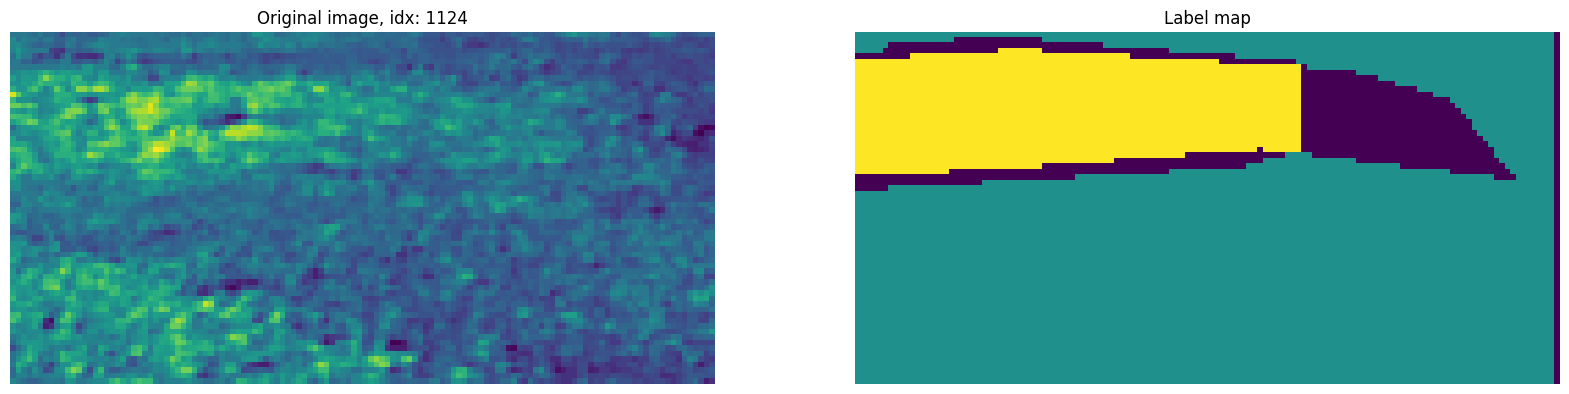

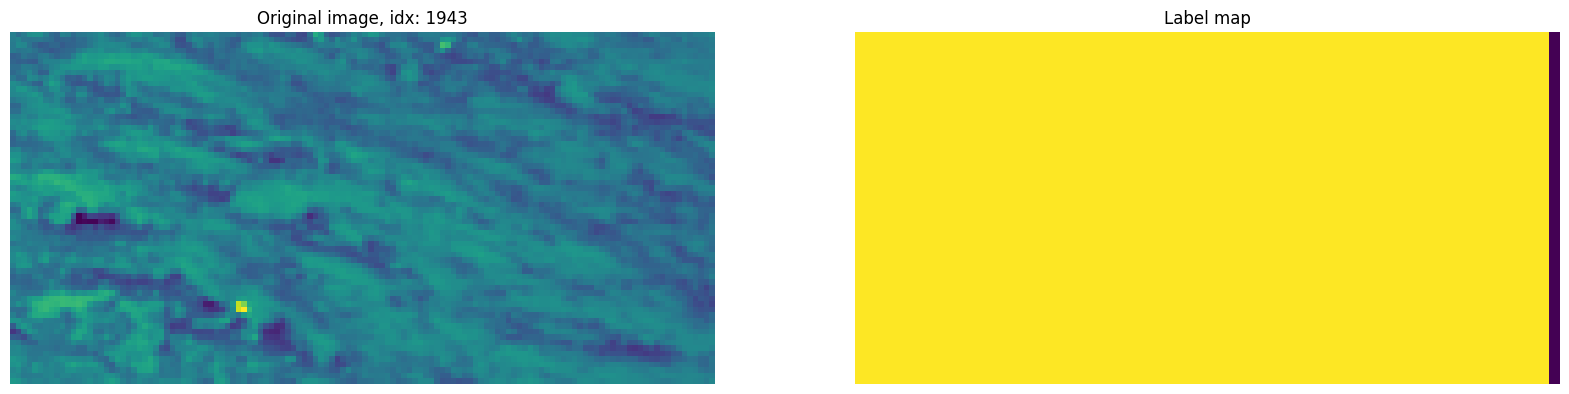

In [4]:
rand_samples = np.random.choice(2615, size=5, replace=False)
for sample in rand_samples:
    plt.figure(figsize=(20, 5))
    plt.subplot(121), plt.imshow(images[sample]), plt.title(f'Original image, idx: {sample}'), plt.axis('off')
    plt.subplot(122), plt.imshow(labels[sample]), plt.title('Label map'), plt.axis('off')
    plt.show()

In [5]:
# 10% of input data to both test and validation sets
test_ratio = 0.05 
validation_ratio = 0.05 / 0.9 

train_val_img, test_img, train_val_lbl, test_lbl = train_test_split(
    images, labels, test_size=test_ratio, random_state=seed
)

train_img, val_img, train_lbl, val_lbl = train_test_split(
    train_val_img, train_val_lbl, test_size=validation_ratio, random_state=seed
)

print(f"Number of images")
print(f"Train: \t\t{len(train_img)}")
print(f"Validation: \t{len(val_img)}")
print(f"Test: \t\t{len(test_img)}")

Number of images
Train: 		2346
Validation: 	138
Test: 		131


In [6]:
# Set number of classes
NUM_CLASSES = 5

# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 1000

## Preprocessing

In [7]:
# Add color channel and rescale pixels between 0 and 1
train_img = train_img[..., np.newaxis] / 255.0
val_img = val_img[..., np.newaxis] / 255.0
test_img = test_img[..., np.newaxis] / 255.0

In [8]:
train_img.shape

(2346, 64, 128, 1)

In [9]:
def load_single_image(image, label, input_size=(64, 128)):

    """

    Load a single image-label pair with the correct shape.

    """

    # Read and preprocess the image

    #image = np.repeat(image, 3, axis=-1)  # Repeat channels to make it RGB

    #image = tf.image.resize(image, input_size) # Resize

    #image = tf.cast(image, tf.float32) / 255.0 # Normalize

    image = tf.image.grayscale_to_rgb(image)

    print(image.shape)



    # Read and preprocess the label

    #label = tf.io.decode_png(label, channels=1)  # Ensure single channel

    #label = tf.image.resize(label, input_size, method='bilinear')  # Resize to fixed size

    label = label[..., np.newaxis] 

    label = tf.cast(label, tf.int32)

    return image, label

In [10]:
category_map = {0:0, 1:1, 2:2, 3:3, 4:4}

def apply_category_mapping(label):

    """Apply category mapping to labels."""

    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )

    return table.lookup(label) #@tf.function



def random_flip(image, label, seed=None):

    """Consistent random horizontal flip."""

    print("----", image.shape)

    if seed is None:
        seed = np.random.randint(0, 1000000)

    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )

    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )

    return image, label

In [11]:
def make_dataset(image_paths, label_paths, batch_size, shuffle=True, augment=False, seed=None):

    """Create a memory-efficient TensorFlow dataset."""

    # Create dataset from file paths

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Load images and labels
    dataset = dataset.map(
        load_single_image,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Apply category mapping
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if augment:
        dataset = dataset.map(
            lambda x, y: random_flip(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
    )


    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [12]:
# Create the datasets

print("Creating datasets...")

train_dataset = make_dataset(
    train_img, train_lbl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    val_img, val_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = make_dataset(
    test_img, test_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("\nDatasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"Input shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
(64, 128, 3)
---- (64, 128, 3)
(64, 128, 3)
(64, 128, 3)

Datasets created!
Input shape: (64, 128, 3)
Images shape: (64, 64, 128, 3)
Labels shape: (64, 64, 128, 1)
Labels dtype: <dtype: 'int32'>


Visualizing examples from the training set:


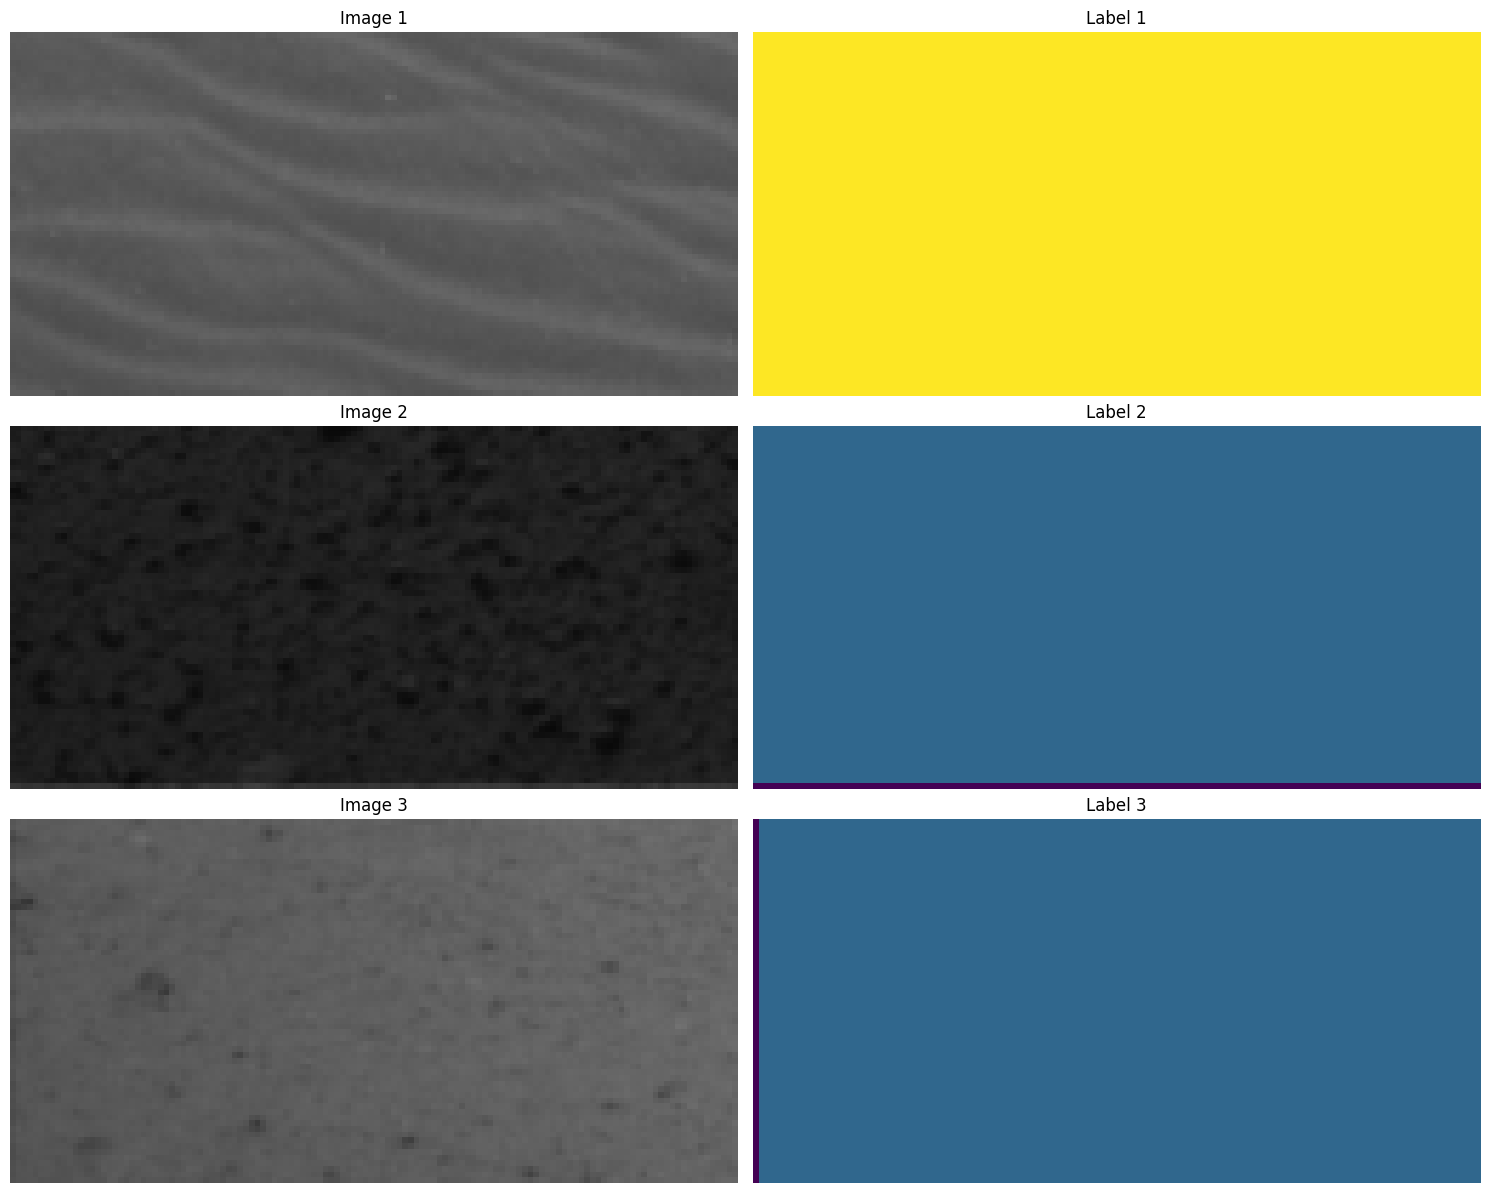

In [13]:
def create_segmentation_colormap(num_classes):

    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """

    return plt.cm.viridis(np.linspace(0, 1, num_classes))


def apply_colormap(label, colormap=None):

    """
    Apply the colormap to a label.
    """

    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored



def plot_sample_batch(dataset, num_samples=3):

    """Display some image and label pairs from the dataset."""

    plt.figure(figsize=(15, 4*num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):

            # Plot original image
            plt.subplot(num_samples, 2, j*2 + 1)
            plt.imshow(images[j])
            plt.title(f'Image {j+1}')
            plt.axis('off')

            # Plot colored label
            plt.subplot(num_samples, 2, j*2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)
            plt.imshow(colored_label)
            plt.title(f'Label {j+1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(train_dataset, num_samples=3)

## Build the Model

In [14]:
def attention_block(x, g, inter_channel):
    # Generate query, key, and value tensors
    theta_x = tfkl.Conv2D(inter_channel, (1,1), padding='same')(x)   # Query
    phi_g = tfkl.Conv2D(inter_channel, (1,1), padding='same')(g)      # Key
    attn = tfkl.Activation('sigmoid')(tfkl.Add()([theta_x, phi_g]))   # Attention Map
    attn = tfkl.Conv2D(1, (1,1), padding='same')(attn)  # Value

    # Multiply attention map with the input feature map
    return tfkl.Multiply()([x, attn])

In [15]:
def attention_u_net(input_shape=input_shape, depth=4, d_conv_count=3, b_conv_count=3, u_conv_count=3, start_filter=32, skip_connections=True, dropout=0.2, NUM_CLASSES=5):

    # Input Layer
    inputs = tfkl.Input(shape=input_shape, name='input_layer')

    x = inputs
    skipped = []

    # Downsampling
    for i in range(depth):

        for j in range(d_conv_count):
            x = tfkl.Conv2D(filters=start_filter,
                            kernel_size=(3, 3),
                            strides=(1, 1),
                            padding='same')(x)
            x = tfkl.BatchNormalization()(x) 
            x = tfkl.ReLU()(x)

        if skip_connections:
            # Save the layer for skip connections
            skipped.append(x)

        x = tfkl.MaxPooling2D(pool_size=(2, 2))(x)
        x = tfkl.Dropout(dropout)(x)

        start_filter = start_filter * 2

    # Bottleneck
    for j in range(b_conv_count):
        x = tfkl.Conv2D(filters=start_filter,
                        kernel_size=(3, 3),
                        strides=(1, 1),
                        padding='same')(x)
        x = tfkl.BatchNormalization()(x) 
        x = tfkl.ReLU()(x)

    start_filter = start_filter // 2

    # Upsampling
    for i in range(depth):

        x = tfkl.UpSampling2D(2, interpolation='bilinear')(x)

        if skip_connections:
            # Apply attention mechanism to the skip connections
            x = attention_block(x, skipped[depth - i - 1], start_filter)

        x = tfkl.Dropout(dropout)(x)

        for j in range(u_conv_count):
            x = tfkl.Conv2D(filters=start_filter,
                            kernel_size=(3, 3),
                            strides=(1, 1),
                            padding='same')(x)
            x = tfkl.BatchNormalization()(x) 
            x = tfkl.ReLU()(x)

        start_filter = start_filter // 2

    # Output Layer
    outputs = tfkl.Conv2D(filters=NUM_CLASSES,
                          kernel_size=(1, 1),
                          strides=(1, 1),
                          padding='same',
                          activation='softmax',
                          name="output_layer")(x)

    model = Model(inputs, outputs, name='Attention_UNet')
    return model


In [16]:
model = attention_u_net()



# Print a detailed summary of the model with expanded nested layers and trainable parameters.

model.summary(expand_nested=True, show_trainable=True)

Model: "Attention_UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 3)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d (Conv2D)   │ (None, 64, 128, │       896 │ input_layer[0… │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       128 │ conv2d[0][0]   │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu (ReLU)      │ (None, 64, 128, │         0 │ batch_normali… │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_1 (Conv2D) │ (None, 64, 128, │     9,248 │ re_lu[0][0]    │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       128 │ conv2d_1[0][0] │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu_1 (ReLU)    │ (None, 64, 128, │         0 │ batch_normali… │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_2 (Conv2D) │ (None, 64, 128, │     9,248 │ re_lu_1[0][0]  │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       128 │ conv2d_2[0][0] │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu_2 (ReLU)    │ (None, 64, 128, │         0 │ batch_normali… │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 32, 64,  │         0 │ re_lu_2[0][0]  │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dropout (Dropout) │ (None, 32, 64,  │         0 │ max_pooling2d… │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_3 (Conv2D) │ (None, 32, 64,  │    18,496 │ dropout[0][0]  │   Y   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 32, 64,  │       256 │ conv2d_3[0][0] │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu_3 (ReLU)    │ (None, 32, 64,  │         0 │ batch_normali… │   -   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_4 (Conv2D) │ (None, 32, 64,  │    36,928 │ re_lu_3[0][0]  │   Y   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 32, 64,  │       256 │ conv2d_4[0][0] │   Y 

 Total params: 11,271,145 (43.00 MB)

 Trainable params: 11,262,313 (42.96 MB)

 Non-trainable params: 8,832 (34.50 KB)

### Metrics

In [17]:
# Define custom Mean Intersection Over Union metric

class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):

    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):

        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)

        if labels_to_exclude is None:

            labels_to_exclude = [0]  # Default to excluding label 0

        self.labels_to_exclude = labels_to_exclude



    def update_state(self, y_true, y_pred, sample_weight=None):

        # Convert predictions to class labels

        y_pred = tf.math.argmax(y_pred, axis=-1)



        # Flatten the tensors

        y_true = tf.reshape(y_true, [-1])

        y_pred = tf.reshape(y_pred, [-1])



        # Apply mask to exclude specified labels

        for label in self.labels_to_exclude:

            mask = tf.not_equal(y_true, label)

            y_true = tf.boolean_mask(y_true, mask)

            y_pred = tf.boolean_mask(y_pred, mask)



        # Update the state

        return super().update_state(y_true, y_pred, sample_weight)

In [18]:
# Compile the model

print("Compiling model...")

model.compile(

    loss=tf.keras.losses.SparseCategoricalCrossentropy(),

    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),

    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]

)

print("Model compiled!")

Compiling model...
Model compiled!


## 🛠️ Train the Model

In [19]:
# Setup callbacks

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    mode="auto",
    min_lr=1e-5
)

In [ ]:
# Train the model

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
).history


# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

Epoch 1/1000


I0000 00:00:1733418377.138124      69 service.cc:145] XLA service 0x7aa188015230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733418377.138214      69 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
W0000 00:00:1733418383.592458      69 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


 1/37 ━━━━━━━━━━━━━━━━━━━━ 33:03 55s/step - accuracy: 0.2735 - loss: 1.6950 - mean_iou: 0.0730

I0000 00:00:1733418414.529959      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.3986 - loss: 1.4602 - mean_iou: 0.1339

W0000 00:00:1733418424.156298      69 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


In [ ]:
# Save the trained model to a file with the accuracy included in the filename

model_filename = 'model.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

In [ ]:
# Plot and display training and validation loss

plt.figure(figsize=(18, 3))

plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)

plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)

plt.title('Cross Entropy')

plt.legend()

plt.grid(alpha=0.3)

plt.show()



# Plot and display training and validation accuracy

plt.figure(figsize=(18, 3))

plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)

plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)

plt.title('Accuracy')

plt.legend()

plt.grid(alpha=0.3)

plt.show()



# Plot and display training and validation mean IoU

plt.figure(figsize=(18, 3))

plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)

plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)

plt.title('Mean Intersection over Union')

plt.legend()

plt.grid(alpha=0.3)

plt.show()

## 📊 Prepare Your Submission



In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [ ]:
X_test_submission = data["test_set"]

print(f"Test X shape: {X_test_submission.shape}")

X_test_submission = X_test_submission[..., np.newaxis] / 255.0

X_test_submission = tf.cast(X_test_submission, tf.float32)

X_test_submission = tf.image.grayscale_to_rgb(X_test_submission)


In [ ]:
# Load UNet model without compiling

model = tfk.models.load_model('/kaggle/working/model.keras', compile=False)



# Compile the model with specified loss, optimizer, and metrics

model.compile(

    loss=tf.keras.losses.SparseCategoricalCrossentropy(),

    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),

    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]

)



# Print a detailed summary of the model with expanded nested layers and trainable parameters.

model.summary(expand_nested=True, show_trainable=True)

In [ ]:
preds = model.predict(X_test_submission)

preds = np.argmax(preds, axis=-1)

print(f"Predictions shape: {preds.shape}")

In [ ]:
def y_to_df(y) -> pd.DataFrame:

    """Converts segmentation predictions into a DataFrame format for Kaggle."""

    n_samples = len(y)

    y_flat = y.reshape(n_samples, -1)

    df = pd.DataFrame(y_flat)

    df["id"] = np.arange(n_samples)

    cols = ["id"] + [col for col in df.columns if col != "id"]

    return df[cols]



# Create and download the csv submission file

submission_filename = f"submission.csv"

submission_df = y_to_df(preds)

submission_df.to_csv(submission_filename, index=False)